In [ ]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
import os

notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_dir)

from sklearn.cluster import DBSCAN
#from torch_scatter import scatter_max, scatter_add, scatter_mean
# from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

def limit_error_bars(y, yerr, upper_limit=1):
    yerr_upper = np.minimum(y + yerr, upper_limit) - y
    yerr_lower = yerr
    return yerr_lower, yerr_upper

/afs/cern.ch/work/a/adevita/miniconda3/envs/pytorch_cpuOnly/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:104: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/afs/cern.ch/work/a/adevita/miniconda3/envs/pytorch_cpuOnly/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:128: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dZ):
/afs/cern.ch/work/a/adevita/miniconda3/envs/pytorch_cpuOnly/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:177: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/afs/cern.ch/work/a/adevita/miniconda3/envs/pytorch_cpuOnly/lib/python3.10/site-packages/dgl/backend/pytorch/s

In [ ]:
from src.utils.inference.pandas_helpers import open_tracking_dataframe
path_tracking = "yourValidationFile.pt"

df_raw = open_tracking_dataframe(path_tracking)

def theta_to_float(x):
    if x is None:
        return None
    elif isinstance(x, (list, np.ndarray)):
        return float(x[0]) if len(x) > 0 else None
    else:
        return float(x)

df_raw["theta"] = df_raw["theta"].apply(theta_to_float)


In [ ]:
import numpy as np
import copy

def max_track_label(x):
    if isinstance(x, list) and len(x) > 0:
        return max(x)
    elif isinstance(x, np.ndarray) and x.size > 0:
        return x.flatten().max()
    elif isinstance(x, (int, float)):
        return x
    else:
        return np.nan
    
event_max = df_raw["eventID"].max()
event_ids = np.arange(0, event_max + 1)

df_raw = df_raw.reset_index(drop=True)

num_reco_tracks = 0
num_fake_tracks = 0
num_merged_tracks = 0
merged_indices = []  

df_raw_with_extraAssignation = df_raw.applymap(lambda x: copy.deepcopy(x))

df_raw_with_extraAssignation["isReco"] = (~df_raw_with_extraAssignation["pid"].isna()).astype(int)
df_raw_with_extraAssignation["isRecoMerged"] = 0
df_raw_with_extraAssignation["isFake"] = (df_raw_with_extraAssignation["pid"].isna()).astype(int)
df_raw_with_extraAssignation["isMerged"] = 0

for event in event_ids:
    
    df_event = df_raw_with_extraAssignation[df_raw_with_extraAssignation["eventID"] == event]
    max_label = df_event["trackLabel"].apply(max_track_label).max()
    
    df_fake_tracks = df_event[df_event["isFake"] == 1]
    
    for row_idx, (eff_list, part_list) in df_fake_tracks[["hitEfficiency", "partIndex"]].iterrows():
    
        good_idx = [i for i, eff in enumerate(eff_list) if eff > 0.72]
        
        if len(good_idx) > 1 and df_fake_tracks.loc[row_idx, "trackLabel"] != 0:

            track_label_arr = df_raw_with_extraAssignation.loc[row_idx, "trackLabel"]
            track_purity_arr = df_raw_with_extraAssignation.loc[row_idx, "hitPurity"]
            track_eff_arr    = df_raw_with_extraAssignation.loc[row_idx, "hitEfficiency"]
            
            df_raw_with_extraAssignation.at[row_idx, "isFake"] = 0
            df_raw_with_extraAssignation.at[row_idx, "isMerged"] = 1
            
            for i in good_idx:
                
                particle_id = part_list[i]
                row_particle = df_raw_with_extraAssignation.index[(df_raw_with_extraAssignation["eventID"] == event) & (df_raw_with_extraAssignation["partIndex"] == particle_id)]

                row_particle = row_particle[0]
                
                df_raw_with_extraAssignation.at[row_particle, "trackLabel"].append(track_label_arr)
                df_raw_with_extraAssignation.at[row_particle, "hitPurity"].append(track_purity_arr[i])
                df_raw_with_extraAssignation.at[row_particle, "hitEfficiency"].append(track_eff_arr[i])
                df_raw_with_extraAssignation.at[row_particle, "isRecoMerged"] = 1
                df_raw_with_extraAssignation.at[row_particle, "isReco"] = 0

/tmp/ipykernel_2491369/2362741409.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_raw_with_extraAssignation = df_raw.applymap(lambda x: copy.deepcopy(x))


In [ ]:
def efficiency_purity_plot(df, minX, maxX, binStep, applyConstraints = False, maxR = 0.05, minDeltaMC = 0.02, minNumHits = 3, minTheta = 10, maxTheta = 170, genStatus = [0,1]):
    
    bins = np.exp(np.arange(np.log(minX), np.log(maxX), binStep))
    
    df_valid = df.copy()
    df_valid = df_valid.dropna()
    mask = df_valid["trackLabel"].apply(lambda x: isinstance(x, list) and 0 in x)
    df_valid.loc[mask, "trackLabel"] = df_valid.loc[mask, "trackLabel"].apply(lambda _: [])
    
    
    df_valid = df_valid[df_valid["trackLabel"].apply(bool)]

    df_valid["theta_deg"] = np.degrees(df_valid["theta"])
    
    if applyConstraints: 
        df_valid = df_valid[(df_valid["theta_deg"] > minTheta) & (df_valid["theta_deg"] < maxTheta)]
        df_valid = df_valid[df_valid["genStatus"].isin(genStatus)]
        df_valid = df_valid[(df_valid["pT"] > 0)]
        df_valid = df_valid[(df_valid["numSIhits"] + df_valid["numCDChits"] > minNumHits)]
        # df_valid = df_valid[(df_valid["R"] < maxR)]
        # df_valid = df_valid[(df_valid["deltaMC"] > minDeltaMC)]
    else:
        df_valid = df_valid[(df_valid["theta_deg"] > minTheta) & (df_valid["theta_deg"] < maxTheta)]
        
    bin_indices = np.digitize(df_valid["pT"], bins)    
    
    efficiencies = []
    purities = []
    bin_centers = []
    errors_eff = []
    errors_pur = []

    for i in range(1, len(bins)):
        df_bin = df_valid[bin_indices == i]
        n_total = len(df_bin)

        bin_centers.append((bins[i-1] + bins[i]) / 2)

        if n_total == 0:
            efficiencies.append(np.nan)
            purities.append(np.nan)
            errors_eff.append(0)
            errors_pur.append(0)
            continue

        eff_arr_raw = df_bin["hitEfficiency"].to_list()
        pur_arr_raw = df_bin["hitPurity"].to_list()

        eff_arr = []
        pur_arr = []

        for idx, el in enumerate(eff_arr_raw):
            if not isinstance(el, (list, np.ndarray)):
                continue  

            max_eff_idx = 0
            max_eff = -np.inf  

            for sub_idx, sub_el in enumerate(el):
                if sub_el > max_eff:
                    max_eff = sub_el
                    max_eff_idx = sub_idx

            eff_arr.append(el[max_eff_idx])
            pur_arr.append(pur_arr_raw[idx][max_eff_idx])
            
        pur_arr = np.array(pur_arr, dtype=float)
        eff_arr = np.array(eff_arr, dtype=float)
        

        # Means
        eff = np.mean(eff_arr)
        pur = np.mean(pur_arr)

        efficiencies.append(eff)
        purities.append(pur)

        # Standard error on the mean
        errors_eff.append(np.std(eff_arr, ddof=1) / np.sqrt(n_total))
        errors_pur.append(np.std(pur_arr, ddof=1) / np.sqrt(n_total))

    bin_centers = np.array(bin_centers)
    efficiencies = np.array(efficiencies)
    purities = np.array(purities)
    errors_eff = np.array(errors_eff)
    errors_pur = np.array(errors_pur)

    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)

    colors = ["#238A8DFF", "#440154FF"]
    markers = ["s", "o"]
    labels = ["Hit efficiency", "Hit purity"]

    # Efficiency
    ax.scatter(bin_centers, efficiencies, marker=markers[0], label=labels[0], s=35)
    yerr_low, yerr_up = limit_error_bars(efficiencies, errors_eff, upper_limit=1)
    ax.errorbar(bin_centers, efficiencies, yerr=[yerr_low, yerr_up], linestyle='none', capsize=4)

    # Purity
    ax.scatter(bin_centers, purities, marker=markers[1], label=labels[1], s=35)
    yerr_low_p, yerr_up_p = limit_error_bars(purities, errors_pur, upper_limit=1)
    ax.errorbar(bin_centers, purities, yerr=[yerr_low_p, yerr_up_p], linestyle='none', capsize=4)

    ax.set_xscale("log")
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0.01, 1.01])
    ax.set_xlabel("$p_T$ [GeV]")
    ax.set_ylabel("Hit efficiency / purity")
    ax.legend(loc="lower right")

    ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
    ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.grid(which='major', linestyle=':', linewidth=0.5, color='black')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

    if applyConstraints:
        textbox_text = (
            r"$Z/\gamma^* \rightarrow f\bar{f}$" "\n"
            r"$m_Z = 91~\mathrm{GeV}$" "\n"
            rf"${minTheta}^\circ < \theta < {maxTheta}^\circ$" "\n"
            rf"$N_\mathrm{{hits}} = N_\mathrm{{SI}} + N_\mathrm{{CDC}} > {minNumHits}$" "\n"
            # rf"$R < {maxR}$" "\n"
            # rf"$\Delta_\mathrm{{MC}} > {minDeltaMC}$" "\n"
            rf"$\text{{genStatus}} \in {genStatus}$"
        )
        
        ax.text(
            0.55, 0.5, textbox_text,
            transform=ax.transAxes,
            fontsize=22,
            verticalalignment='center',
            horizontalalignment='left',
            linespacing=1.4,
            bbox=dict(
                boxstyle="round,pad=0.35",
                facecolor="none",
                edgecolor="none"
                )
        )
        
    else:
        textbox_text = (
            r"$Z/\gamma^* \rightarrow f\bar{f}$" "\n"
            r"$m_Z = 91~\mathrm{GeV}$" "\n"
            rf"${minTheta}^\circ < \theta < {maxTheta}^\circ$"
        )
        
        ax.text(
            0.62, 0.33, textbox_text,
            transform=ax.transAxes,
            fontsize=22,
            verticalalignment='center',
            horizontalalignment='left',
            linespacing=1.4,
            bbox=dict(
                boxstyle="round,pad=0.35",
                facecolor="none",
                edgecolor="none"
                )
        )
    
   

    plt.show()    
   

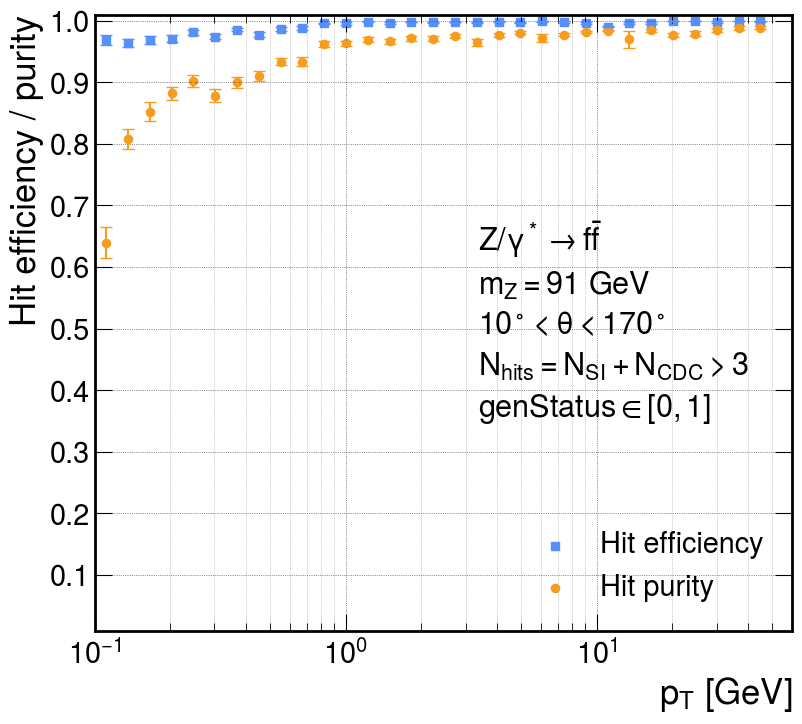

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False

efficiency_purity_plot(df_raw_with_extraAssignation,0.1,60,0.2,True)

In [7]:
def trackingEfficiencyPlot(df, minX, maxX, binStep, applyConstraints = False, maxR = 0.05, minDeltaMC = 0.02, minNumHits = 3, minTheta = 10, maxTheta = 170, genStatus = [0,1]):
    
    bins = np.exp(np.arange(np.log(minX), np.log(maxX), binStep))
    
    df_valid = df.copy()
    df_valid = df_valid.dropna()
    
    mask = df_valid["trackLabel"].apply(lambda x: isinstance(x, list) and 0 in x)
    df_valid.loc[mask, "trackLabel"] = df_valid.loc[mask, "trackLabel"].apply(lambda _: [])
    
    df_valid["theta_deg"] = np.degrees(df_valid["theta"])
    
    if applyConstraints: 
        df_valid = df_valid[(df_valid["theta_deg"] > minTheta) & (df_valid["theta_deg"] < maxTheta)]
        df_valid = df_valid[df_valid["genStatus"].isin(genStatus)]
        df_valid = df_valid[(df_valid["pT"] > 0)]
        df_valid = df_valid[(df_valid["numSIhits"] + df_valid["numCDChits"] > minNumHits)]
        # df_valid = df_valid[(df_valid["R"] < maxR)]
        # df_valid = df_valid[(df_valid["deltaMC"] > minDeltaMC)]
    else:
        df_valid = df_valid[(df_valid["theta_deg"] > minTheta) & (df_valid["theta_deg"] < maxTheta)]
          
    bin_indices = np.digitize(df_valid["pT"], bins)    
    
    efficiencies = []
    bin_centers = []
    errors = []

    for i in range(1, len(bins)):
        df_bin = df_valid[bin_indices == i]
        n_total = len(df_bin)
        if n_total == 0:
            efficiencies.append(np.nan)
            errors.append(0)
            bin_centers.append((bins[i-1] + bins[i])/2)
            continue
        
        n_matched = df_bin["trackLabel"].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()
    
        eff = n_matched / n_total
        efficiencies.append(eff)
        
        # Binomial error
        err = np.sqrt(eff * (1-eff) / n_total)
        errors.append(err)
        bin_centers.append((bins[i-1] + bins[i])/2)


    bin_centers = np.array(bin_centers)
    efficiencies = np.array(efficiencies)
    errors = np.array(errors)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    colors = ["#238A8DFF"]
    marker = ["s"]
    label = ["GGTF IDEA"]

    plt.scatter(
        bin_centers,
        efficiencies,
        label=label[0],
        marker=marker[0],
        c=[colors[0] for _ in range(len(bin_centers))],
        s=30
    )

    yerr_lower, yerr_upper = limit_error_bars(efficiencies, errors, upper_limit=1)
    plt.errorbar(bin_centers, efficiencies, yerr=[yerr_lower, yerr_upper], ecolor=colors[0], linestyle='none', capsize=4)

    plt.xlabel("$p_T$ [GeV]")
    plt.ylabel("Tracking efficiency")
    plt.xscale("log")
    plt.xlim([minX, maxX])
    plt.ylim([0.01, 1.01])
    plt.legend(loc="lower right")

    ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
    ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.minorticks_on()
    ax.grid(which='major', linestyle=':', linewidth=0.5, color='black')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

    plt.rcParams["text.usetex"] = False
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['font.size'] = 25
    plt.rcParams['axes.labelsize'] = 25
    plt.rcParams['xtick.labelsize'] = 25
    plt.rcParams['ytick.labelsize'] = 25
    plt.rcParams['legend.fontsize'] = 25
    leg = ax.get_legend()
    leg._legend_box.align = "left"

    if applyConstraints:
        textbox_text = (
            r"$Z/\gamma^* \rightarrow f\bar{f}$" "\n"
            r"$m_Z = 91~\mathrm{GeV}$" "\n"
            rf"${minTheta}^\circ < \theta < {maxTheta}^\circ$" "\n"
            rf"$N_\mathrm{{hits}} = N_\mathrm{{SI}} + N_\mathrm{{CDC}} > {minNumHits}$" "\n"
            # rf"$R < {maxR}$" "\n"
            # rf"$\Delta_\mathrm{{MC}} > {minDeltaMC}$" "\n"
            rf"$\text{{genStatus}} \in {genStatus}$"
        )
        
        ax.text(
            0.45, 0.3, textbox_text,
            transform=ax.transAxes,
            fontsize=22,
            verticalalignment='center',
            horizontalalignment='left',
            linespacing=1.4,
            bbox=dict(
                boxstyle="round,pad=0.35",
                facecolor="none",
                edgecolor="none"
                )
        )
        
    else:
        textbox_text = (
            r"$Z/\gamma^* \rightarrow f\bar{f}$" "\n"
            r"$m_Z = 91~\mathrm{GeV}$" "\n"
            rf"${minTheta}^\circ < \theta < {maxTheta}^\circ$"
        )
        
        ax.text(
            0.62, 0.33, textbox_text,
            transform=ax.transAxes,
            fontsize=22,
            verticalalignment='center',
            horizontalalignment='left',
            linespacing=1.4,
            bbox=dict(
                boxstyle="round,pad=0.35",
                facecolor="none",
                edgecolor="none"
                )
        )

    plt.show()
    

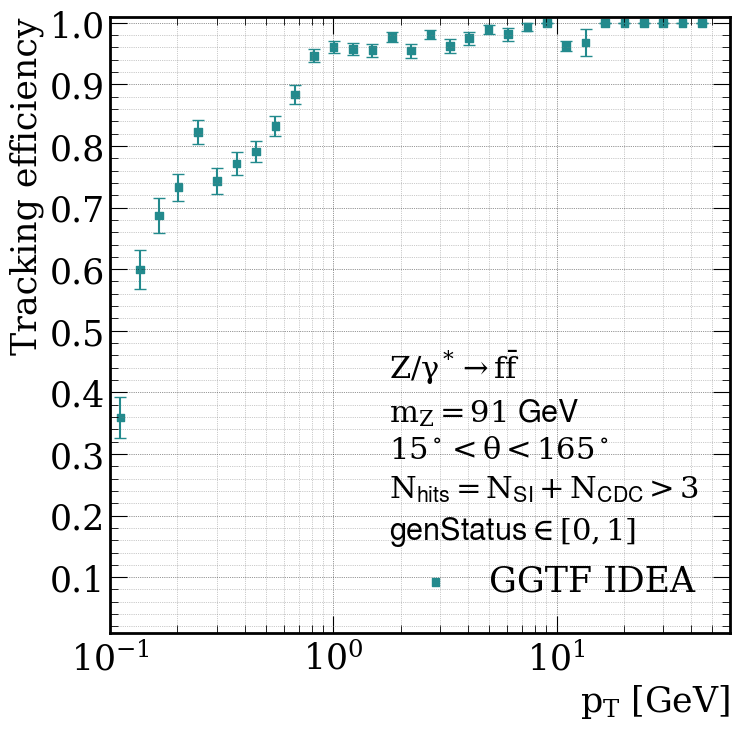

In [9]:
plt.rcParams['text.usetex'] = False

trackingEfficiencyPlot(df_raw,0.1,60,0.2,True, genStatus=[0,1], minTheta = 15, maxTheta = 165)

## Event Display

In [ ]:
from src.utils.inference.pandas_helpers import open_tracking_dataframe
path_hits = "yourFileForEventDisplay.pt"
df_hits = open_tracking_dataframe(path_hits)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os


def plot_event_display(df_dict, file_number, event_number):
    """
    Display an event with two projections (XY and ZY planes)
    for a given file_number and event_number.

    Parameters
    ----------
    df_dict : dict or pandas.DataFrame
        Dictionary (or DataFrame) containing event data with keys:
        'fileID', 'eventID', 'pos_x', 'pos_y', 'pos_z', 'hit_type', 'clusterID'.
    file_number : int
        The file ID of the event to display.
    event_number : int
        The event ID to display.
    """

    if not isinstance(df_dict, pd.DataFrame):
        df = pd.DataFrame({k: np.concatenate(v) for k, v in df_dict.items()})
    else:
        df = df_dict


    mask = (df["fileID"] == file_number) & (df["eventID"] == event_number)
    df_event = df[mask]

    if df_event.empty:
        print(f"No event found for fileID={file_number}, eventID={event_number}")
        return

  
    unique_clusters = np.unique(df_event["clusterID"])
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax_xy, ax_zy = axes

 
    for color, cl in zip(colors, unique_clusters):
        cluster_hits = df_event[df_event["clusterID"] == cl]

      
        ax_xy.scatter(cluster_hits["pos_x"], cluster_hits["pos_y"],
                      label=f"Cluster {cl}", s=30, alpha=0.8, color=color, edgecolor='black')
      
        ax_zy.scatter(cluster_hits["pos_z"], cluster_hits["pos_y"],
                      s=30, alpha=0.8, color=color, edgecolor='black')

 
    ax_xy.set_xlabel("x [mm]")
    ax_xy.set_ylabel("y [mm]")
    
    ax_zy.set_xlabel("z [mm]")
    ax_zy.set_ylabel("y [mm]")

    ax_xy.grid(True, linestyle=':')
    ax_zy.grid(True, linestyle=':')

    ax_xy.legend(title="Cluster ID", fontsize=10, loc="best")

    plt.tight_layout()
    plt.show()
    

def interactive_event_display(df_flat, file_number, event_number, 
                              outdir="./interactive_events", color_by="clusterID",
                              pos_cols=("pos_x","pos_y","pos_z"),
                              extra_hover=None, filename_suffix=""):
    """
    Creates an interactive 3D event display for a given event, using Plotly.
    """
    if not os.path.exists(outdir):
        os.makedirs(outdir)

  
    df_event = df_flat[(df_flat["fileID"] == file_number) & (df_flat["eventID"] == event_number)]
    if df_event.empty:
        print(f"No hits found for fileID={file_number}, eventID={event_number}")
        return


    df_event[color_by] = df_event[color_by].astype(str)

    hover_cols = extra_hover if extra_hover else []

    
    fig = px.scatter_3d(
        df_event,
        x=pos_cols[0],
        y=pos_cols[1],
        z=pos_cols[2],
        color=color_by,
        symbol="hit_type",
        size_max=6,
        opacity=0.8,
        template="plotly_dark",
        hover_data=hover_cols
    )

 
    fig.update_traces(marker=dict(line=dict(width=0)))
    
    fig.add_scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode='markers+text',
        marker=dict(size=6, color='red', symbol='x'),
        text=['(0,0,0)'],
        textposition='top center',
        name='Origin'
    )
    

    fig.update_layout(
        legend_title=color_by,
        coloraxis_showscale=False
    )

    filename = f"{outdir}/event_{file_number}_{event_number}{filename_suffix}.html"
    fig.write_html(filename)
    print(f"Interactive event display saved to {filename}")



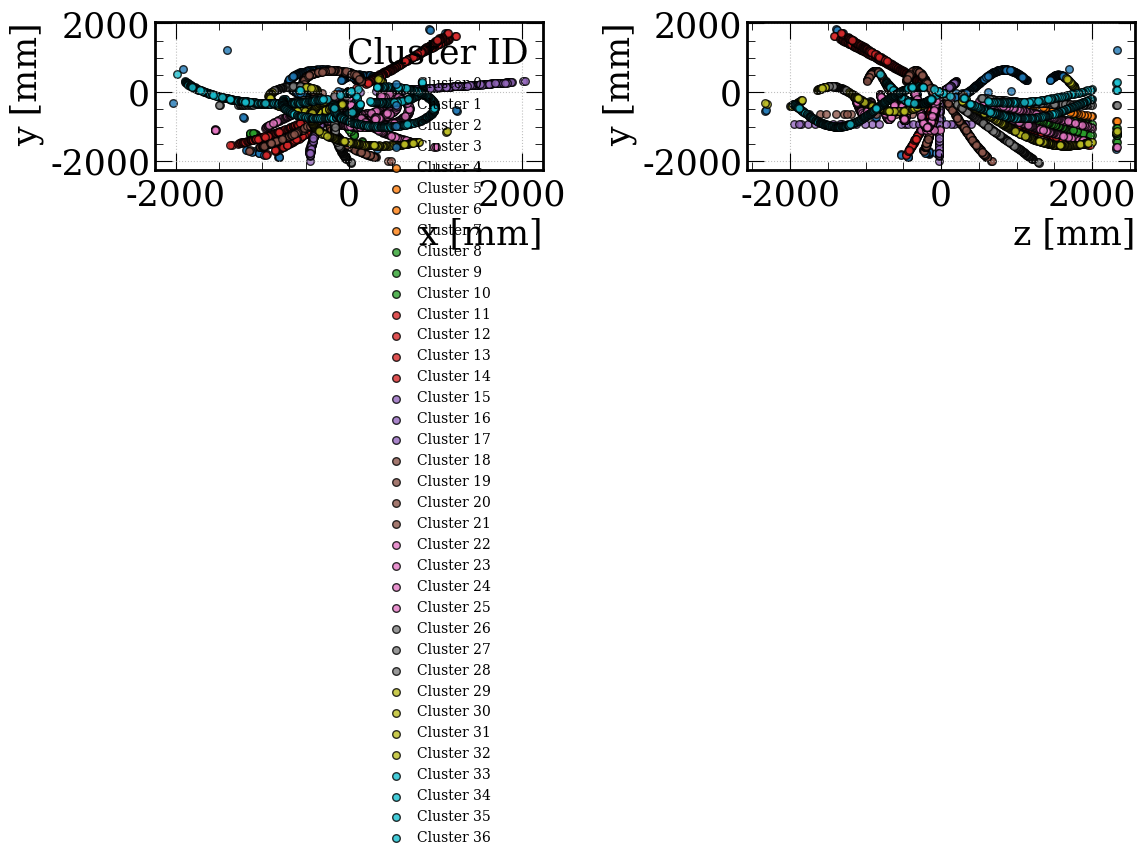

/tmp/ipykernel_2033465/275142371.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event[color_by] = df_event[color_by].astype(str)


Interactive event display saved to ./interactive_events/event_1_0.html


/tmp/ipykernel_2033465/275142371.py:89: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Interactive event display saved to ./interactive_events/event_1_0_particles.html


/tmp/ipykernel_2033465/275142371.py:89: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Interactive event display saved to ./interactive_events/event_1_0_clusters.html


In [ ]:
plot_event_display(df_hits, file_number=1, event_number=0)

interactive_event_display(
    df_hits,
    file_number=1,
    event_number=0,
    color_by="clusterID",
    extra_hover=["particle_number", "particle_number_original", "hit_type", "pos_x", "pos_y", "pos_z"]
)

interactive_event_display(
    df_hits,
    file_number=1,
    event_number=0,
    color_by="particle_number",
    extra_hover=["clusterID", "particle_number_original", "hit_type", "pos_x", "pos_y", "pos_z"],
    filename_suffix="_particles"
)

interactive_event_display(
    df_hits,
    file_number=1,
    event_number=0,
    color_by="clusterID",
    pos_cols=("embedding_x", "embedding_y", "embedding_z"),
    extra_hover=["clusterID", "particle_number_original", "hit_type", "embedding_x", "embedding_y", "embedding_z","beta"],
    filename_suffix="_clusters"
)

